In [1]:
import sys


sys.path.append("..")
from flame_analysis_model import *
import keras
import torch
from keras import layers
from keras.datasets import mnist, fashion_mnist
import numpy as np
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
from typing import List
from dataclasses import dataclass
from torch.utils.data import DataLoader, TensorDataset
from gen_models_utilities import (
    device, create_ring_gaussians,
    make_loader, compute_diversity_metric, plot_model_diagnostics, plot_latent_interpolation
)


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [3]:
df = pd.read_csv("flame_front_po_post0.csv")
print(df.keys())
# Select meaningful physical variables
features = ['u', 'v', 'T', 'c', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
       'curvature', 'stretch_rate', 'disp_speed_density_weighted',
       'abs_flame_prop_vel_normal', 'flow_velocity_normal',
       'flow_velocity_tangential', 'tangential_strain_rate',
       'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
       'vorticity', 'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O',
       'omega_OH', 'omega_HO2', 'omega_H2O2', 'omega_N2', 'Le_def']

X = StandardScaler().fit_transform(df[features])
c = X[:, 5]

Index(['x', 'y', 'u', 'v', 'T', 'c', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
       'curvature', 'stretch_rate', 'disp_speed_density_weighted',
       'abs_flame_prop_vel_normal', 'flow_velocity_normal',
       'flow_velocity_tangential', 'tangential_strain_rate',
       'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
       'vorticity', 'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O',
       'omega_OH', 'omega_HO2', 'omega_H2O2', 'omega_N2', 'Le_def'],
      dtype='object')


In [4]:
#| code-fold: false
def vae_loss(x: torch.Tensor, x_recon: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor,
             beta: float = 1.0, reconstruction_variance: float = 0.1):
    """
    Compute VAE loss = Reconstruction loss + beta * KL divergence.

    Args:
        x: Original data
        x_recon: Reconstructed data
        mu: Mean of latent distribution
        logvar: Log-variance of latent distribution
        beta: Weight for KL term (beta=1 is standard VAE, beta>1 is beta-VAE)
        reconstruction_variance: Assumed variance of reconstruction distribution
    """
    # Reconstruction loss (MSE scaled by assumed variance)
    recon_loss = torch.sum((x - x_recon) ** 2, dim=1) / (2 * reconstruction_variance)

    # KL divergence between q(z|x) and p(z) = N(0,I)
    # KL(N(mu, sigma^2) || N(0,1)) = 0.5 * sum(mu^2 + sigma^2 - log(sigma^2) - 1)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

    # Total loss (negative ELBO)
    return (recon_loss + beta * kl_div).mean(), recon_loss.mean(), kl_div.mean()

In [5]:
#| code-fold: false
@dataclass
class VAEHistory:
    """Training history for VAE."""
    loss: List[float]
    recon_loss: List[float]
    kl_loss: List[float]
    diversity: List[float]


def train_vae(
    data: np.ndarray,
    x_dim: int = 2,
    z_dim: int = 2,
    hidden_dim: int = 128,
    batch_size: int = 256,
    epochs: int = 200,
    lr: float = 1e-3,
    beta: float = 1.0,
    reconstruction_variance: float = 0.1,
    print_every: int = 50
):
    """
    Train a VAE on the provided data.

    Args:
        data: Training data (numpy array)
        x_dim: Dimension of data space
        z_dim: Dimension of latent space
        hidden_dim: Hidden layer dimension
        batch_size: Batch size for training
        epochs: Number of training epochs
        lr: Learning rate
        beta: Weight for KL term (beta-VAE parameter)
        reconstruction_variance: Assumed variance of reconstruction distribution
        print_every: Print progress every N epochs

    Returns:
        Trained VAE model and training history
    """
    # Setup data loader
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    vae = VAE(num_input=x_dim, num_latent=z_dim, num_hidden=hidden_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=lr)

    # Training history
    history = VAEHistory(loss=[], recon_loss=[], kl_loss=[], diversity=[])

    print(f"Training VAE for {epochs} epochs...")
    print(f"Parameters: z_dim={z_dim}, beta={beta}, recon_var={reconstruction_variance}, lr={lr}")

    vae.train()
    for epoch in range(epochs):
        epoch_losses = []
        epoch_recon = []
        epoch_kl = []

        for batch in loader:
            batch = batch.to(device)

            # Forward pass
            x_recon, mu, logvar, z = vae(batch)

            # Compute loss
            loss, recon, kl = vae_loss(batch, x_recon, mu, logvar, beta, reconstruction_variance)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            epoch_recon.append(recon.item())
            epoch_kl.append(kl.item())

        # Record metrics
        mean_loss = np.mean(epoch_losses)
        mean_recon = np.mean(epoch_recon)
        mean_kl = np.mean(epoch_kl)

        # Compute diversity (sample from prior and decode)
        with torch.no_grad():
            z_samples = torch.randn(2048, z_dim, device=device)
            x_samples = vae.decode(z_samples)
            diversity = compute_diversity_metric(x_samples)

        history.loss.append(mean_loss)
        history.recon_loss.append(mean_recon)
        history.kl_loss.append(mean_kl)
        history.diversity.append(diversity)

        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:03d}/{epochs} | Loss: {mean_loss:.3f} | "
                  f"Recon: {mean_recon:.3f} | KL: {mean_kl:.3f} | Div: {diversity:.3f}")
    return vae, history

In [6]:
# Train the VAE
X = torch.tensor(X, dtype=torch.float32, device=device)
num_latent = 4
vae, history = train_vae(
    X,
    x_dim=X.shape[1],
    z_dim=num_latent,
    hidden_dim=30,
    epochs=2000,
    batch_size=256,
    lr=1e-3,
    beta=1.0,
    reconstruction_variance=0.1,
    print_every=50
)

Training VAE for 2000 epochs...
Parameters: z_dim=4, beta=1.0, recon_var=0.1, lr=0.001
Epoch 001/2000 | Loss: 186.775 | Recon: 186.701 | KL: 0.074 | Div: 0.003
Epoch 050/2000 | Loss: 11.759 | Recon: 4.183 | KL: 7.576 | Div: 0.722
Epoch 100/2000 | Loss: 10.299 | Recon: 2.960 | KL: 7.339 | Div: 0.854
Epoch 150/2000 | Loss: 9.746 | Recon: 2.445 | KL: 7.301 | Div: 0.810
Epoch 200/2000 | Loss: 9.430 | Recon: 2.239 | KL: 7.191 | Div: 0.826
Epoch 250/2000 | Loss: 9.291 | Recon: 2.105 | KL: 7.186 | Div: 0.839
Epoch 300/2000 | Loss: 9.235 | Recon: 2.057 | KL: 7.177 | Div: 0.839
Epoch 350/2000 | Loss: 9.145 | Recon: 2.023 | KL: 7.122 | Div: 0.821
Epoch 400/2000 | Loss: 9.113 | Recon: 1.989 | KL: 7.124 | Div: 0.837
Epoch 450/2000 | Loss: 9.109 | Recon: 1.986 | KL: 7.123 | Div: 0.867
Epoch 500/2000 | Loss: 9.003 | Recon: 1.925 | KL: 7.078 | Div: 0.864
Epoch 550/2000 | Loss: 8.983 | Recon: 1.909 | KL: 7.074 | Div: 0.840
Epoch 600/2000 | Loss: 8.946 | Recon: 1.907 | KL: 7.040 | Div: 0.844
Epoch 650/

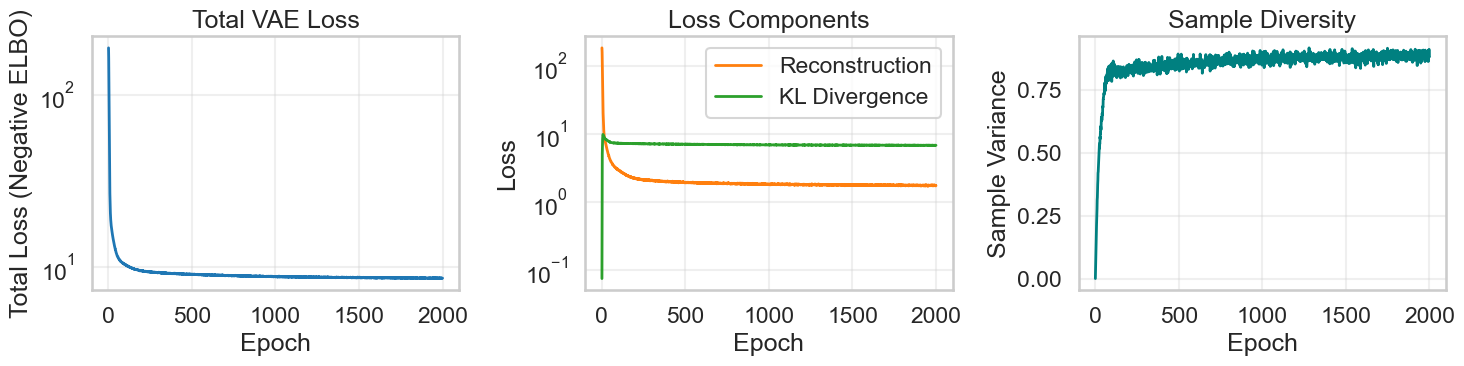

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs = np.arange(1, len(history.loss) + 1)

# Total loss
axes[0].plot(epochs, history.loss, color='tab:blue', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss (Negative ELBO)')
axes[0].set_title('Total VAE Loss')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Reconstruction vs KL
axes[1].plot(epochs, history.recon_loss, label='Reconstruction', linewidth=2, color='tab:orange')
axes[1].plot(epochs, history.kl_loss, label='KL Divergence', linewidth=2, color='tab:green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Components')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Diversity
axes[2].plot(epochs, history.diversity, color='teal', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Sample Variance')
axes[2].set_title('Sample Diversity')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

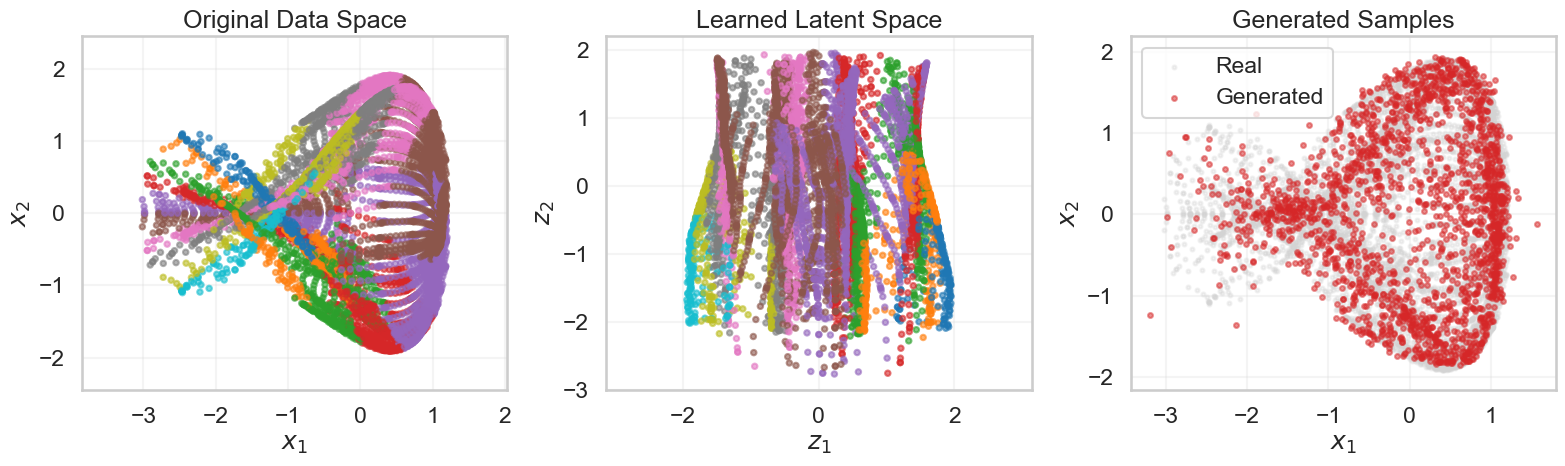

In [8]:
# Encode all data points to latent space

vae.eval()
with torch.no_grad():
    # Move data to device and ensure float32
    X_tensor = X.to(device, dtype=torch.float32)

    # Encode: returns (mu, logvar)
    mu, logvar = vae.encode(X_tensor)
    z_encoded = mu.cpu().numpy()  # typically visualize μ (mean of latent distribution)

    # Generate samples from a 2D standard normal prior
    z_prior = torch.randn(2000, num_latent, device=device)
    x_generated = vae.decode(z_prior).cpu().numpy()

# --- Visualization ---

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# (1) Original data space
sc0 = axes[0].scatter(X.cpu()[:, 0], X.cpu()[:, 1], c=c, cmap='tab10', s=15, alpha=0.6)
axes[0].set_title('Original Data Space')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.2)

# (2) Latent space (encoded μ)
sc1 = axes[1].scatter(z_encoded[:, 0], z_encoded[:, 1], c=c, cmap='tab10', s=15, alpha=0.6)
axes[1].set_title('Learned Latent Space')
axes[1].set_xlabel('$z_1$')
axes[1].set_ylabel('$z_2$')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.2)

# (3) Generated samples from prior
axes[2].scatter(X.cpu()[:, 0], X.cpu()[:, 1], c='lightgray', s=8, alpha=0.3, label='Real')
axes[2].scatter(x_generated[:, 0], x_generated[:, 1], c='tab:red', s=12, alpha=0.5, label='Generated')
axes[2].set_title('Generated Samples')
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].axis('equal')
axes[2].grid(True, alpha=0.2)
axes[2].legend()

plt.tight_layout()
plt.show()